# Part-of-Speech tagging (Bahasa) with Keras

## Ensuring reproducibility

In [1]:
import numpy as np
CUSTOM_SEED = 42
np.random.seed(CUSTOM_SEED)

## Getting an annotated corpus

In [15]:
import csv
import re

sentences = []

with open('../corpus/Indonesian_Manually_Tagged_Corpus_ID.tsv') as file:
    reader = csv.reader(file, delimiter='\t')
    sentence = []
    
    for row in reader:
        if re.match("\<kalimat id\=\w+\>" ,row[0]):
            pass
        elif re.match("\<\/kalimat\>", row[0]):
            sentences.append(sentence)
            sentence = []
        else:
            sentence.append((row[0], row[1].upper()))

sentences = sentences[:5000]
print('#corpus: %s sentences' % len(sentences))

#corpus: 5000 sentences


In [16]:
tags = set([
    tag for sentence in sentences 
    for _, tag in sentence
])
print('nb_tags: %s ntags: %s' % (len(tags), tags))

nb_tags: 23 ntags: {'CD', 'CC', 'DT', 'SYM', 'FW', 'X', 'UH', 'RP', 'JJ', 'NND', 'WH', 'PRP', 'Z', 'PR', 'NN', 'NNP', 'SC', 'OD', 'VB', 'IN', 'RB', 'MD', 'NEG'}


## Datasets preprocessing for supervised learning

In [17]:
train_test_cutoff = int(.80 * len(sentences)) 
training_sentences = sentences[:train_test_cutoff]
testing_sentences = sentences[train_test_cutoff:]
train_val_cutoff = int(.25 * len(training_sentences))
validation_sentences = training_sentences[:train_val_cutoff]
training_sentences = training_sentences[train_val_cutoff:]

## Feature engineering

In [18]:
def add_basic_features(sentence_terms, index):
    """ Compute some very basic word features.
        :param sentence_terms: [w1, w2, ...] 
        :type sentence_terms: list
        :param index: the index of the word 
        :type index: int
        :return: dict containing features
        :rtype: dict
    """
    term = sentence_terms[index]
    return {
        'nb_terms': len(sentence_terms),
        'term': term,
        'is_first': index == 0,
        'is_last': index == len(sentence_terms) - 1,
#         'is_capitalized': term[0].upper() == term[0],
#         'is_all_caps': term.upper() == term,
#         'is_all_lower': term.lower() == term,
#         'prefix-1': term[0],
#         'prefix-2': term[:2],
#         'prefix-3': term[:3],
#         'suffix-1': term[-1],
#         'suffix-2': term[-2:],
#         'suffix-3': term[-3:],
#         'prev_word': '' if index == 0 else sentence_terms[index - 1],
#         'next_word': '' if index == len(sentence_terms) - 1 else sentence_terms[index + 1]
    }

In [19]:
def untag(tagged_sentence):
    """ 
    Remove the tag for each tagged term.
    :param tagged_sentence: a POS tagged sentence
    :type tagged_sentence: list
    :return: a list of tags
    :rtype: list of strings
    """
    return [w for w, _ in tagged_sentence]

def transform_to_dataset(tagged_sentences):
    """
    Split tagged sentences to X and y datasets and append some basic features.
    :param tagged_sentences: a list of POS tagged sentences
    :param tagged_sentences: list of list of tuples (term_i, tag_i)
    :return: 
    """
    X, y = [], []
    for pos_tags in tagged_sentences:
        for index, (term, class_) in enumerate(pos_tags):
            # Add basic NLP features for each sentence term
            X.append(add_basic_features(untag(pos_tags), index))
            y.append(class_)
    return X, y

In [20]:
X_train, y_train = transform_to_dataset(training_sentences)
X_test, y_test = transform_to_dataset(testing_sentences)
X_val, y_val = transform_to_dataset(validation_sentences)

## Features encoding

In [21]:
import gc

from sklearn.feature_extraction import DictVectorizer

# Fit our DictVectorizer with our set of features
dict_vectorizer = DictVectorizer(sparse=False)
print(type(X_train), type(X_test), type(X_val))
dict_vectorizer.fit(X_train + X_test + X_val)

# Convert dict features to vectors
X_train = dict_vectorizer.transform(X_train)
X_test = dict_vectorizer.transform(X_test)
X_val = dict_vectorizer.transform(X_val)

<class 'list'> <class 'list'> <class 'list'>


In [22]:
from sklearn.preprocessing import LabelEncoder

# Fit LabelEncoder with our list of classes
label_encoder = LabelEncoder()
label_encoder.fit(y_train + y_test + y_val)

# Encode class values as integers
y_train = label_encoder.transform(y_train)
y_test = label_encoder.transform(y_test)
y_val = label_encoder.transform(y_val)

In [23]:
# Convert integers to dummy variables (one hot encoded)
from keras.utils import np_utils

y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
y_val = np_utils.to_categorical(y_val)

Using TensorFlow backend.


## Building a Keras model

In [24]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation

def build_model(input_dim, hidden_neurons, output_dim):
    """
    Construct, compile and return a Keras model which will be used to fit/predict
    """
    model = Sequential([
        Dense(hidden_neurons, input_dim=input_dim),
        Activation('relu'),
        Dropout(0.2),
        Dense(hidden_neurons),
        Activation('relu'),
        Dropout(0.2),
        Dense(output_dim, activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

## Creating a wrapper between Keras API and Scikit-Learn

In [25]:
from keras.wrappers.scikit_learn import KerasClassifier
model_params = {
    'build_fn': build_model,
    'input_dim': X_train.shape[1],
    'hidden_neurons': 512,
    'output_dim': y_train.shape[1],
    'epochs': 5,
    'batch_size': 256,
    'verbose': 1,
    'validation_data': (X_val, y_val),
    'shuffle': True
}
clf = KerasClassifier(**model_params)

## Training our Keras model

In [26]:
hist = clf.fit(X_train, y_train)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 82129 samples, validate on 25562 samples
Epoch 1/5
82129/82129 [==============================] - ETA: 0s - loss: 1.0399 - acc: 0.701 - 173s 2ms/step - loss: 1.0379 - acc: 0.7017 - val_loss: 0.4870 - val_acc: 0.8634
Epoch 2/5
82129/82129 [==============================] - 164s 2ms/step - loss: 0.1542 - acc: 0.9614 - val_loss: 0.4294 - val_acc: 0.8799
Epoch 3/5
82129/82129 [==============================] - 144s 2ms/step - loss: 0.0804 - acc: 0.9797 - val_loss: 0.4405 - val_acc: 0.8867
Epoch 4/5
82129/82129 [==============================] - 141s 2ms/step - loss: 0.0639 - acc: 0.9826 - val_loss: 0.4290 - val_acc: 0.8804
Epoch 5/5
82129/82129 [==============================] - 149s 2ms/step - loss: 0.0585 - acc: 0.9831 - val_loss: 0.4402 - val_acc:

In [27]:
import matplotlib.pyplot as plt
def plot_model_performance(train_loss, train_acc, train_val_loss, train_val_acc):
    """ Plot model loss and accuracy through epochs. """
    blue= '#34495E'
    green = '#2ECC71'
    orange = '#E23B13'
    # plot model loss
    fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 8))
    ax1.plot(range(1, len(train_loss) + 1), train_loss, blue, linewidth=5, label='training')
    ax1.plot(range(1, len(train_val_loss) + 1), train_val_loss, green, linewidth=5, label='validation')
    ax1.set_xlabel('# epoch')
    ax1.set_ylabel('loss')
    ax1.tick_params('y')
    ax1.legend(loc='upper right', shadow=False)
    ax1.set_title('Model loss through #epochs', color=orange, fontweight='bold')
    # plot model accuracy
    ax2.plot(range(1, len(train_acc) + 1), train_acc, blue, linewidth=5, label='training')
    ax2.plot(range(1, len(train_val_acc) + 1), train_val_acc, green, linewidth=5, label='validation')
    ax2.set_xlabel('# epoch')
    ax2.set_ylabel('accuracy')
    ax2.tick_params('y')
    ax2.legend(loc='lower right', shadow=False)
    ax2.set_title('Model accuracy through #epochs', color=orange, fontweight='bold')

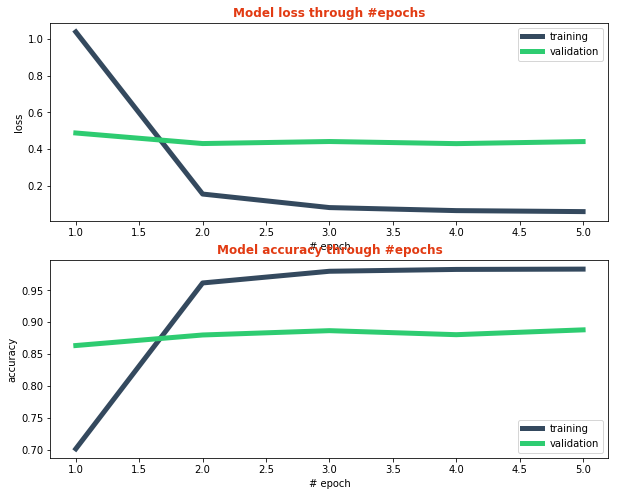

In [28]:
plot_model_performance(
    train_loss=hist.history.get('loss', []),
    train_acc=hist.history.get('acc', []),
    train_val_loss=hist.history.get('val_loss', []),
    train_val_acc=hist.history.get('val_acc', [])
)

## Evaluating our multilayer perceptron

In [29]:
score = clf.score(X_test, y_test)
print(score)

26377/26377 [==============================] - 17s 649us/step
0.9409333889373318


## Visualizing the model

In [32]:
from keras.utils import plot_model
plot_model(clf.model, to_file='model.png', show_shapes=True)

## Save the Keras model

In [31]:
clf.model.save('/tmp/keras_mlp.h5')

OSError: Unable to create file (unable to open file: name = '/tmp/keras_mlp.h5', errno = 2, error message = 'No such file or directory', flags = 13, o_flags = 302)